# Employee Satisfaction vs Attrition
## Logistic Regression Modelling
>### Author: Lu (Christina) Jin

# Setup: Import all libraries

In [2]:
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as scipy
import plotly.graph_objects as go

import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score 
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.ticker import PercentFormatter
from scipy import stats
from pylab import rcParams
rcParams['figure.figsize'] = (20, 10)
sns.set_style('darkgrid')
plt.style.use('seaborn-darkgrid')

# Analysis of Variance test
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
from numpy import absolute
from scipy.stats import f_oneway

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Part A: Logistic Regression - Attrition

## 1. Introducing Attrition Data




> ### 1.1 Acquiring Data and Basic Cleaning
*   Read data from Google Sheet
*   Remove any N/A data points


In [3]:
# Read data
data_work_path="https://docs.google.com/spreadsheets/d/e/2PACX-1vSG-GQwdpZkTC-UV9cTMCjhSwkmc5VNb-IzH5yG6neHxk3dB_a-Ttlg-8Nynttq_NmnROAt-OZmx9Ax/pub?gid=925359326&single=true&output=csv"
work_df= pd.read_csv(data_work_path)
work_df

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,0,SALES,MEDIUM
1,0.75,0.81,2,247,4,0,0,0,HR,SMALL
2,0.54,0.81,4,257,2,0,0,0,ADMIN,SMALL
3,0.60,0.65,4,160,2,0,0,0,IS,SMALL
4,0.85,0.92,4,151,3,1,0,0,IS,MEDIUM
...,...,...,...,...,...,...,...,...,...,...
11244,0.94,0.79,4,136,2,0,0,0,SALES,MEDIUM
11245,0.73,0.97,6,189,2,0,1,0,SALES,SMALL
11246,0.67,0.77,5,167,2,0,0,0,ADMIN,MEDIUM
11247,0.98,0.67,4,209,6,0,0,0,MKT,SMALL


In [4]:
# Drop incomplete entries
work_df = work_df.dropna()

print(work_df.info())
work_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11249 entries, 0 to 11248
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_satisfaction    11249 non-null  float64
 1   last_performance_rating  11249 non-null  float64
 2   workload                 11249 non-null  int64  
 3   avg_montly_hours         11249 non-null  int64  
 4   tenure_years             11249 non-null  int64  
 5   ergo_issues              11249 non-null  int64  
 6   attrit                   11249 non-null  int64  
 7   promo_in_last_5_years    11249 non-null  int64  
 8   dept                     11249 non-null  object 
 9   salary                   11249 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 966.7+ KB
None


,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years
count,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000
mean,0.612957,0.716225,3.799716,201.176727,3.499600,0.144991,0.239577,0.021869
std,0.248235,0.171378,1.232190,50.058105,1.469892,0.352107,0.426844,0.146261
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,201.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


> ### 1.2 Data Interpretation

In [5]:
# Explore all the varaibles
print(list(work_df))

#Explore quantitative variabes
print("Department:", work_df.dept.unique())
print("Salary: ", work_df.salary.unique())

['employee_satisfaction', 'last_performance_rating', 'workload', 'avg_montly_hours', 'tenure_years', 'ergo_issues', 'attrit', 'promo_in_last_5_years', 'dept', 'salary']
Department: ['SALES' 'HR' 'ADMIN' 'IS' 'TECH' 'PM' 'FIN' 'EXEC' 'MKT' 'RTD']
Salary:  ['MEDIUM' 'SMALL' 'LARGE']


> #### **Dataset Information:**

This set of data contains attrition and other information of almost 11250 employee from a certain firm. This dataset could be used to analyze and further predict for factors that lead to employee attrition.



> #### **Variables Interpretation:**

* employee_satisfaction: a 0-1 numerical rating of how satisfied are employees with the firm (rated from 0.09 the lowest and highest as 1)
* last_performance_rating: a numerical rating of how people performed during last period (rated from 0.36 to 1.00, with the performance to be higher as the rating goes up).
* workload: describes how heavy the work load is for each person (from 2(least workload) to 7(most workload)).
* avg_montly_hours: average working hours per month (from 96 hrs to 110 hrs).
* tenure_years: the number of years that this person has been on his/her tenure.
* ergo_issues: A binary field that is set to either 1 for when this person has ergonomic issue(s), or 0 for this person does not have ergonomic issue.
* attrit: A binary field that is set to either 1 or 0, which indicates whether this person is involved in an attrition (0 means not being attrited)
* promo_in_last_5_years: A binary field that is set to either 1 for this person has been promoted within the last 5 years, or 0 for this person have not been promoted for the last 5 years.
* dept: a categorical field indicates which department is this person currently working in.
* salary: a categorical field indicates the general amount of a person's salary (Small, Medium and Large).





> ### 1.3 Perform Light Modification

*   Filter dataset to two groups with one group focusing on people who attrited, and the other focusing on people who have not attrited








In [6]:
# perform filter
attrit_df = work_df.loc[(work_df['attrit'] == 1)]
not_attrit_df = work_df.loc[(work_df['attrit'] == 0)]
attrit_df

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
7,0.42,0.49,2,152,3,0,1,0,ADMIN,SMALL
8,0.09,0.90,7,289,4,0,1,0,PM,SMALL
11,0.54,0.74,4,164,2,0,1,0,SALES,SMALL
17,0.10,0.94,6,255,4,0,1,0,TECH,SMALL
18,0.44,0.51,2,134,3,0,1,0,HR,MEDIUM
...,...,...,...,...,...,...,...,...,...,...
11214,0.11,0.84,6,300,5,1,1,0,ADMIN,SMALL
11220,0.11,0.81,6,305,4,0,1,0,SALES,SMALL
11226,0.11,0.97,6,310,4,0,1,0,FIN,MEDIUM
11239,0.39,0.54,2,127,3,0,1,0,SALES,SMALL


In [7]:
not_attrit_df

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,0,SALES,MEDIUM
1,0.75,0.81,2,247,4,0,0,0,HR,SMALL
2,0.54,0.81,4,257,2,0,0,0,ADMIN,SMALL
3,0.60,0.65,4,160,2,0,0,0,IS,SMALL
4,0.85,0.92,4,151,3,1,0,0,IS,MEDIUM
...,...,...,...,...,...,...,...,...,...,...
11243,0.54,0.88,3,251,2,0,0,0,TECH,SMALL
11244,0.94,0.79,4,136,2,0,0,0,SALES,MEDIUM
11246,0.67,0.77,5,167,2,0,0,0,ADMIN,MEDIUM
11247,0.98,0.67,4,209,6,0,0,0,MKT,SMALL


## 2. EDA & Regression Approach 


> ### 2.1 Explore Correlation Between Attrition and Quantitative Variables
Observations:
*   It looks like all 5 quantitative variables all have some what of an impact on the attrition.
*   Employees who have higher satisfaction with their work/the firm are not likely no attrit.
*   Employees who performed either above or under average during last period are more likely attrit. Employees who rated somewhere around average are not.
*   Employees who have either very small workload or very heavy workload are more likely to attrit. Somewhere in between are not as likely.
*   Employees who have worked for either longer hours or shorter hours than normal each month on average are more likely to attrit.
*   Employees who have shorter tenure period are likely to attrit.
*   The significance of each of the above 4 variates will have to be further analyzed in later sections.
*   Ergonomic issues and promotions doesn't seem to have much impact on whether employees attrit or not.




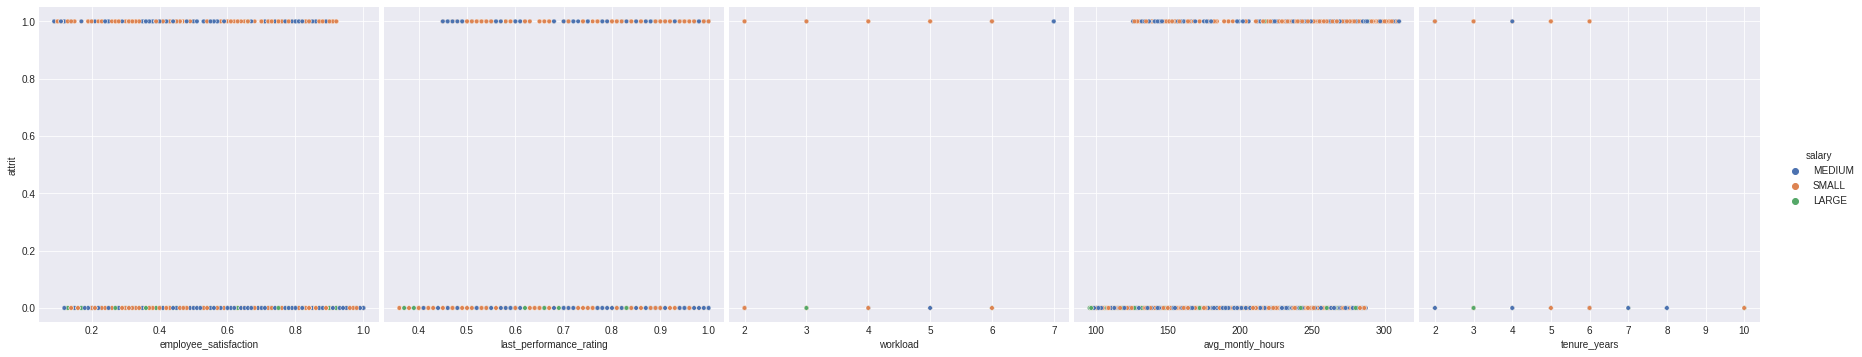

In [8]:
ax = sns.pairplot(work_df, x_vars=['employee_satisfaction','last_performance_rating','workload','avg_montly_hours','tenure_years'], y_vars = ['attrit'], hue='salary',plot_kws={"s": 20}, palette = 'deep', height=5)

**Except the variable 'tenure years', the scatter plot above does not show strong evidence of a correlation between attriation and any other quanlitative variables. Thus, netc we are going to look at each variable closely to see whether any of them are significant.**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



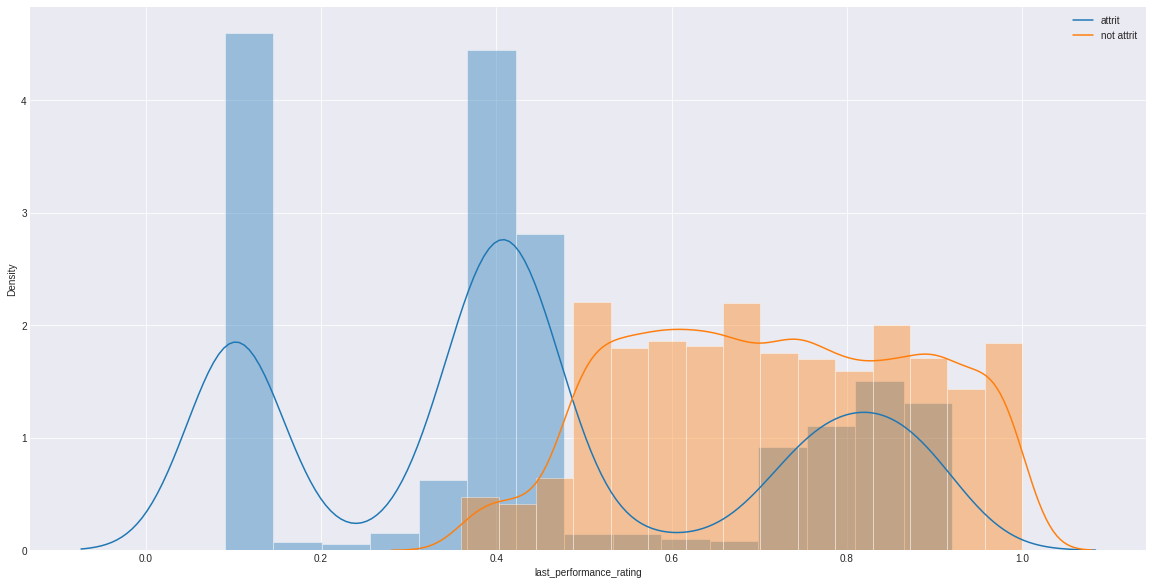

In [9]:
# empoyee satisfaction
ax = sns.distplot(attrit_df['employee_satisfaction'], hist=True, bins=15)
ax = sns.distplot(not_attrit_df['last_performance_rating'], hist=True, bins=15)
plt.legend(['attrit','not attrit'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



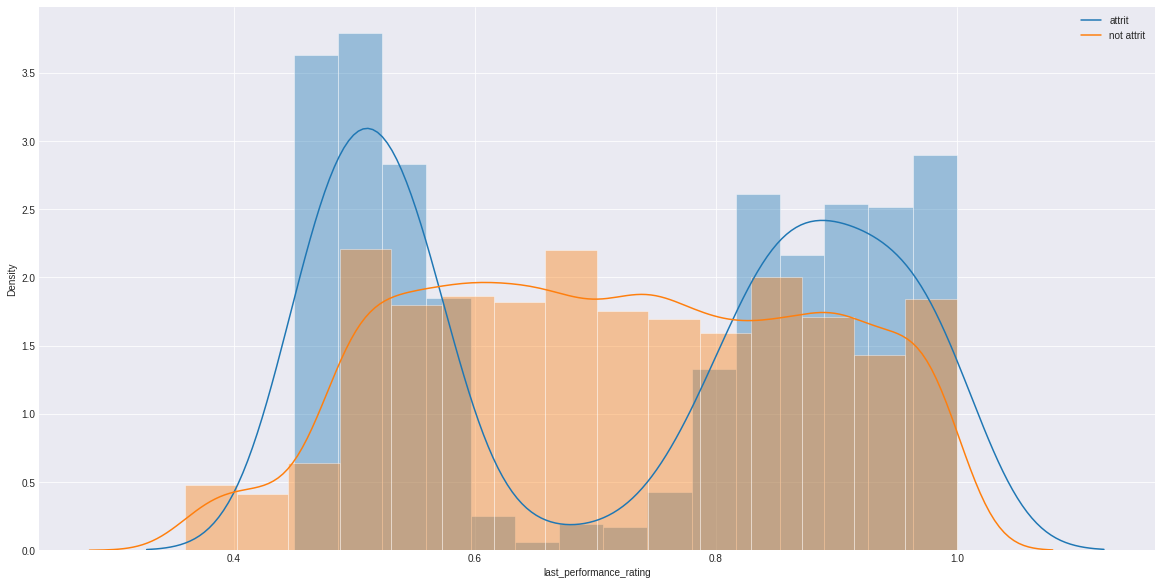

In [10]:
# last perfomance rating
ax = sns.distplot(attrit_df['last_performance_rating'], hist=True, bins=15)
ax = sns.distplot(not_attrit_df['last_performance_rating'], hist=True, bins=15)
plt.legend(['attrit','not attrit'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



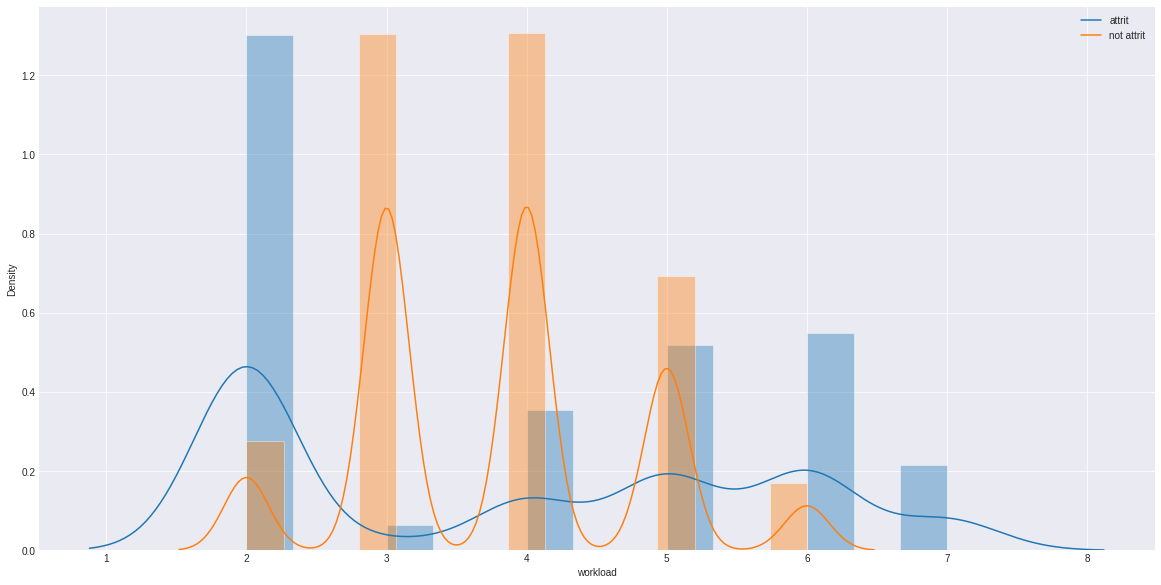

In [11]:
# workloads
ax = sns.distplot(attrit_df['workload'], hist=True, bins=15)
az = sns.distplot(not_attrit_df['workload'], hist=True, bins=15)
plt.legend(['attrit','not attrit'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



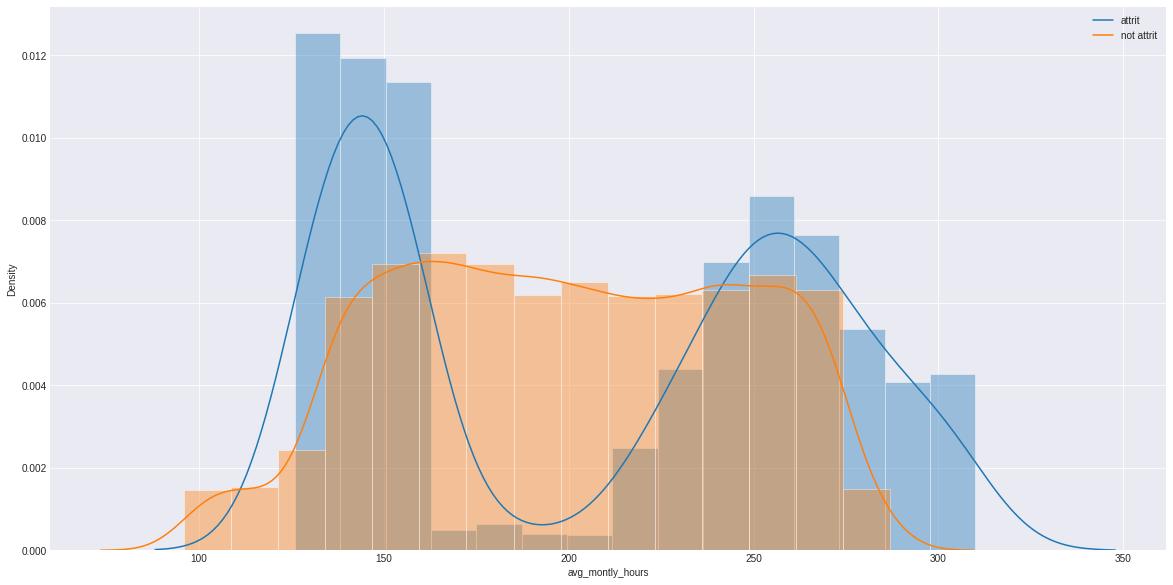

In [12]:
# average monthly working hours
ax = sns.distplot(attrit_df['avg_montly_hours'], hist=True, bins=15)
ax = sns.distplot(not_attrit_df['avg_montly_hours'], hist=True, bins=15)
plt.legend(['attrit','not attrit'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



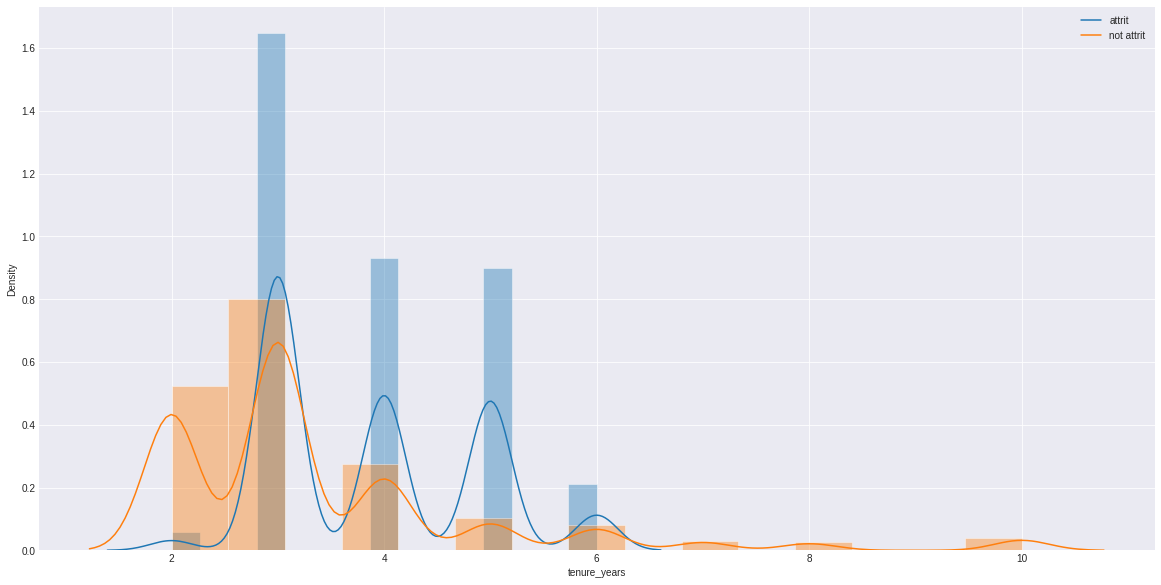

In [13]:
# tenured years
ax = sns.distplot(attrit_df['tenure_years'], hist=True, bins=15)
az = sns.distplot(not_attrit_df['tenure_years'], hist=True, bins=15)
plt.legend(['attrit','not attrit'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



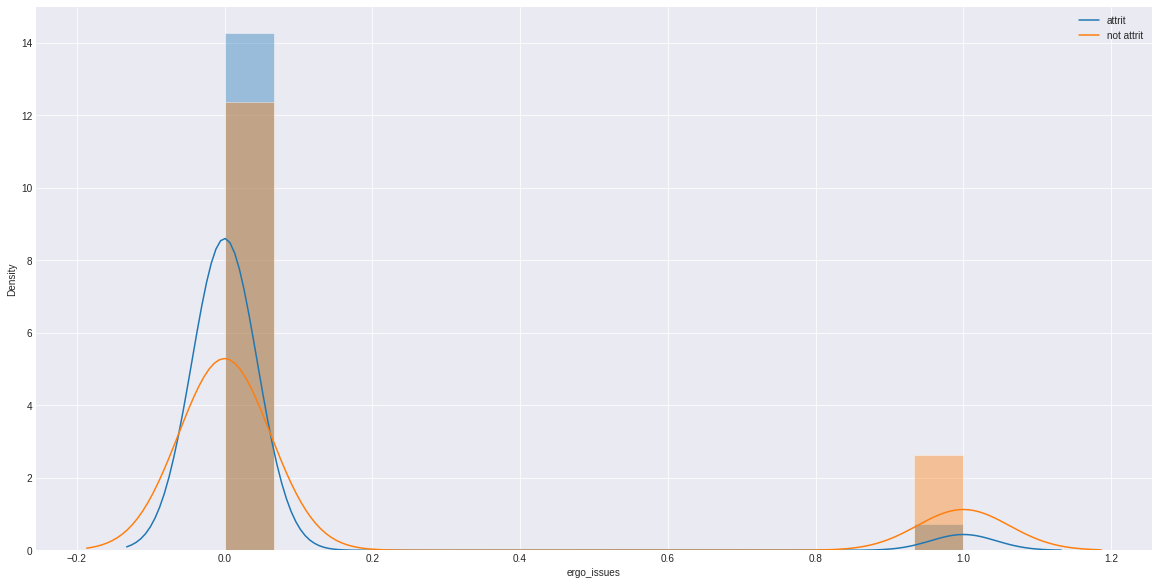

In [14]:
# ergo issues
ax = sns.distplot(attrit_df['ergo_issues'], hist=True, bins=15)
az = sns.distplot(not_attrit_df['ergo_issues'], hist=True, bins=15)
plt.legend(['attrit','not attrit'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



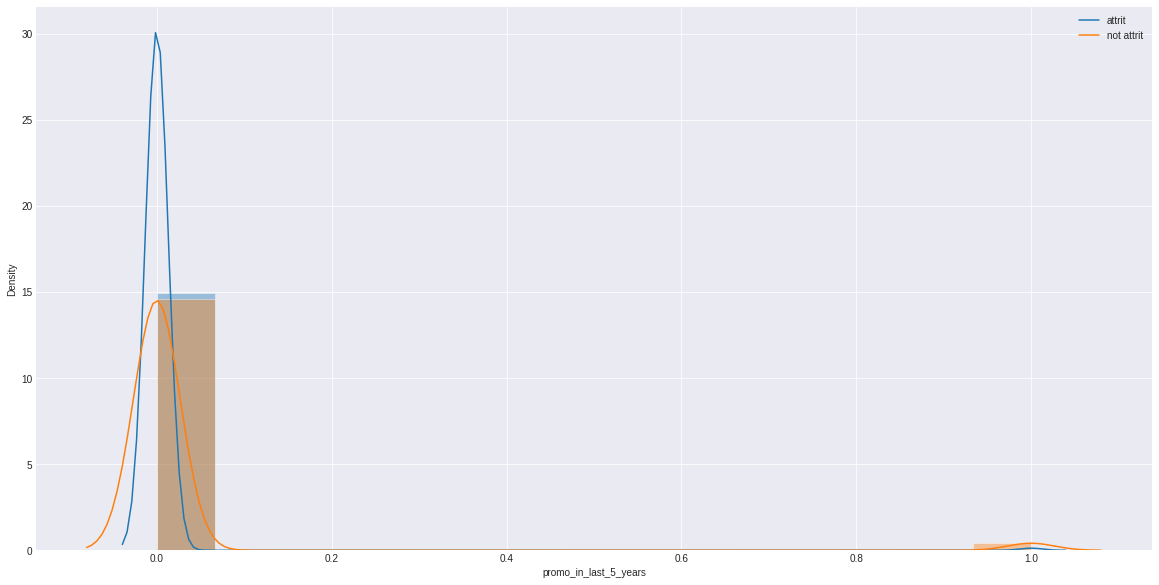

In [15]:
# promotions
ax = sns.distplot(attrit_df['promo_in_last_5_years'], hist=True, bins=15)
az = sns.distplot(not_attrit_df['promo_in_last_5_years'], hist=True, bins=15)
plt.legend(['attrit','not attrit'])

> ### 2.2 Explore Correlation Between Attrition and Qualitative Variables 
Observations:
*   There are slightly more people attriting within the sales, tech and HR department. But this might due to the fact that there are way more employees in these departments comparing to others.
*   The less the salaries are, the higher chances that employees with attrit.



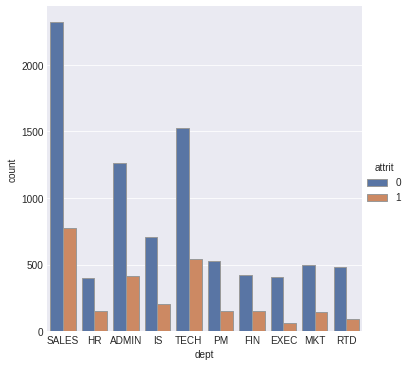

In [16]:
# department
ax = sns.catplot(data=work_df, x='dept', hue="attrit", kind="count", 
                 palette="deep", edgecolor=".6")

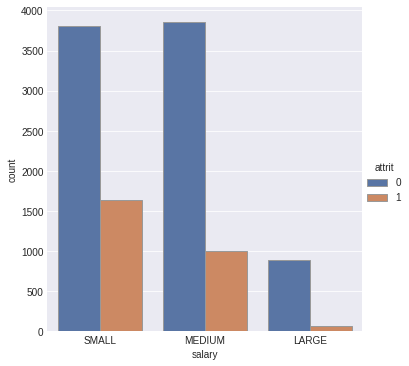

In [17]:
# salary
ax = sns.catplot(data=work_df, x='salary', order=['SMALL','MEDIUM', 'LARGE'],
                 hue="attrit", kind="count", palette="deep", edgecolor=".6")

> ### 2.3 Significance level and Hypothesis Testing
* The Null Hypothesis (H0) is that the variable being investigated is affecting the attrition rate.
* The Alternate Hypothesis (H1) is that the variable being investigated is NOT affecting the attrition rate.
* The p-value will be set to .05





In [18]:
#Employee's Satisfaction
#generate independent samples
perf = work_df['employee_satisfaction']
perf_0 = perf.loc[work_df['attrit']==0]
perf_1 = perf.loc[work_df['attrit']==1]

#compare samples
stat, p = f_oneway(perf_0, perf_1)
print('Empoyee Satisfaction:')
print('Statistics=%.3f, p=%.3f' % (stat, p))

#interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')
print()

# ----------------------------------------------------- #

#Performance 
#generate independent samples
perf = work_df['last_performance_rating']
perf_0 = perf.loc[work_df['attrit']==0]
perf_1 = perf.loc[work_df['attrit']==1]

#compare samples
stat, p = f_oneway(perf_0, perf_1)
print('Last Performance Rating:')
print('Statistics=%.3f, p=%.3f' % (stat, p))

#interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')
print()

# ----------------------------------------------------- #

# Workload 
#generate independent samples
perf = work_df['workload']
perf_0 = perf.loc[work_df['attrit']==0]
perf_1 = perf.loc[work_df['attrit']==1]

#compare samples
stat, p = f_oneway(perf_0, perf_1)
print('Workload:')
print('Statistics=%.3f, p=%.3f' % (stat, p))

#interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')
print()

# ----------------------------------------------------- #

# Average Monthly Working Hours 
#generate independent samples
perf = work_df['avg_montly_hours']
perf_0 = perf.loc[work_df['attrit']==0]
perf_1 = perf.loc[work_df['attrit']==1]

#compare samples
stat, p = f_oneway(perf_0, perf_1)
print('Average Monthly Working Hours:')
print('Statistics=%.3f, p=%.3f' % (stat, p))

#interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')
print()

# ----------------------------------------------------- #

# Tenure Years 
#generate independent samples
perf = work_df['tenure_years']
perf_0 = perf.loc[work_df['attrit']==0]
perf_1 = perf.loc[work_df['attrit']==1]

#compare samples
stat, p = f_oneway(perf_0, perf_1)
print('Tenure Years:')
print('Statistics=%.3f, p=%.3f' % (stat, p))

#interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')
print()

Empoyee Satisfaction:
Statistics=2001.216, p=0.000
Different distributions (reject H0)

Last Performance Rating:
Statistics=1.575, p=0.210
Same distributions (fail to reject H0)

Workload:
Statistics=9.489, p=0.002
Different distributions (reject H0)

Average Monthly Working Hours:
Statistics=67.929, p=0.000
Different distributions (reject H0)

Tenure Years:
Statistics=244.590, p=0.000
Different distributions (reject H0)



In [19]:
salary_df = work_df[['salary','attrit']]
salary_df

,salary,attrit
0,MEDIUM,0
1,SMALL,0
2,SMALL,0
3,SMALL,0
4,MEDIUM,0
...,...,...
11244,MEDIUM,0
11245,SMALL,1
11246,MEDIUM,0
11247,SMALL,0


In [20]:
# create contingency table
contingency_table=pd.crosstab(salary_df['salary'],salary_df['attrit'])
contingency_table

attrit,0,1
salary,,
LARGE,895,64
MEDIUM,3850,995
SMALL,3809,1636


In [21]:
# convert contingency table to percentages
contingency_table.astype('float').div(contingency_table.sum(axis=1),axis=0)*100.00

attrit,0,1
salary,,
LARGE,93.326382,6.673618
MEDIUM,79.463364,20.536636
SMALL,69.954086,30.045914


In [22]:
# create a reverse contingency table and convert it to percentages
contingency_table2=pd.crosstab(salary_df['attrit'],salary_df['salary'])
contingency_table2.astype('float').div(contingency_table2.sum(axis=1),axis=0)*100.00

salary,LARGE,MEDIUM,SMALL
attrit,,,
0,10.462941,45.008183,44.528875
1,2.374768,36.920223,60.705009


## 3. Logistic Regression Analysis
* Implement Sci-Kit Learn for Logistic Regression
* Investigate the two selected variables which makes significant impact on the attrition: employee satisfaction and tenure years.


> ### 3.1 Employee Satisfaction vs Attrition Model, Performance and Predictions

In [23]:
X_train, X_test, y_train, y_test = train_test_split(work_df[['employee_satisfaction']], work_df[['attrit']], test_size = .2, random_state=67)

#Initialize Logistic Regressor 
model = LogisticRegression()

#Fit the model
model.fit(X_train, y_train.values.ravel())

#score the model
print('Model score:', model.score(X_test, y_test))

X_test

Model score: 0.792


,employee_satisfaction
6695,0.43
5886,0.85
9509,0.91
7483,0.83
5850,0.51
...,...
4119,0.65
528,0.94
4994,0.11
3261,0.50


In [24]:
#Get predictions for the test set.
#Each value corresponds to an attrition outcome of 0 (no) or 1 (yes)
model.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [25]:
#probabilities of each record.
#The structure below has two data points per record.
#The first data point contains the probability of this employee not attriting
#The second data point contains the probability of this employee attriting
model.predict_proba(X_test)

array([[0.66235424, 0.33764576],
       [0.90153421, 0.09846579],
       [0.91941851, 0.08058149],
       ...,
       [0.37754625, 0.62245375],
       [0.7171904 , 0.2828096 ],
       [0.67050806, 0.32949194]])

In [26]:
#To understand how the model performs, take a look at the actuals, predictions, and probabilities
prediction_df = pd.DataFrame(model.predict(X_test), columns = {'Prediction'}).set_index([pd.Index(X_test.index)])
probability_df = pd.DataFrame(model.predict_proba(X_test)).set_index([pd.Index(X_test.index)])
all_together_df = X_test.join(y_test).join(prediction_df).join(probability_df)
all_together_df

,employee_satisfaction,attrit,Prediction,0,1
6695,0.43,1,0,0.662354,0.337646
5886,0.85,0,0,0.901534,0.098466
9509,0.91,0,0,0.919419,0.080581
7483,0.83,0,0,0.894827,0.105173
5850,0.51,0,0,0.724571,0.275429
...,...,...,...,...,...
4119,0.65,0,0,0.814690,0.185310
528,0.94,0,0,0.927204,0.072796
4994,0.11,1,1,0.377546,0.622454
3261,0.50,0,0,0.717190,0.282810


In [27]:
#use the model to predict attrition rate for arbitrary satisfaction rate values
empsat_arbitrary_values = pd.DataFrame(data = {'employee_satisfaction': [0.09,0.16,0.20,0.24,0.35,0.41,0.48,0.56,0.63,0.71,0.77,0.83,0.92,0.99]})
empsat_arbitrary_values.join(pd.DataFrame(model.predict(empsat_arbitrary_values), columns = {'Prediction'}).set_index([pd.Index(empsat_arbitrary_values.index)]))

,employee_satisfaction,Prediction
0,0.09,1
1,0.16,1
2,0.20,1
3,0.24,1
4,0.35,0
5,0.41,0
6,0.48,0
7,0.56,0
8,0.63,0
9,0.71,0


> ### 3.2 Tenure Years vs Attrition Model, Performane and Predictions

In [28]:
X_train, X_test, y_train, y_test = train_test_split(work_df[['tenure_years']], work_df[['attrit']], test_size = .2, random_state=1)

#Initialize Logistic Regressor 
model = LogisticRegression()

#Fit the model
model.fit(X_train, y_train.values.ravel())

#score the model
print('Model score:', model.score(X_test, y_test))

X_test

Model score: 0.7564444444444445


,tenure_years
8543,4
8414,3
11164,4
447,2
4365,3
...,...
9721,5
6781,3
6184,2
8311,5


In [29]:
#Get predictions for the test set.
#Each value corresponds to an attrition outcome of 0 (no) or 1 (yes)
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
#probabilities of each record.
#The structure below has two data points per record.
#The first data point contains the probability of this employee not attriting
#The second data point contains the probability of this employee attriting
model.predict_proba(X_test)

array([[0.74205097, 0.25794903],
       [0.78054995, 0.21945005],
       [0.74205097, 0.25794903],
       ...,
       [0.81473751, 0.18526249],
       [0.69939902, 0.30060098],
       [0.78054995, 0.21945005]])

In [31]:
#To understand how the model performs, take a look at the actuals, predictions, and probabilities
prediction_df = pd.DataFrame(model.predict(X_test), columns = {'Prediction'}).set_index([pd.Index(X_test.index)])
probability_df = pd.DataFrame(model.predict_proba(X_test)).set_index([pd.Index(X_test.index)])
all_together_df = X_test.join(y_test).join(prediction_df).join(probability_df)
all_together_df

,tenure_years,attrit,Prediction,0,1
8543,4,0,0,0.742051,0.257949
8414,3,0,0,0.780550,0.219450
11164,4,0,0,0.742051,0.257949
447,2,0,0,0.814738,0.185262
4365,3,0,0,0.780550,0.219450
...,...,...,...,...,...
9721,5,0,0,0.699399,0.300601
6781,3,0,0,0.780550,0.219450
6184,2,0,0,0.814738,0.185262
8311,5,1,0,0.699399,0.300601


In [32]:
#use the model to predict attrition rate for arbitrary satisfaction rate values
workload_arbitrary_values = pd.DataFrame(data = {'tenure_years': [1,2,3,4,5,6,7,8,9,10]})
workload_arbitrary_values.join(pd.DataFrame(model.predict(workload_arbitrary_values), columns = {'Prediction'}).set_index([pd.Index(workload_arbitrary_values.index)]))

,tenure_years,Prediction
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,1
9,10,1


# Part B: Logistic Regression - Transaction

## 1. Introducing Transaction Data




> ### 1.1 Acquiring Data and Basic Cleaning
*   Read data from Google Sheet
*   Remove any N/A data points


In [33]:
# Read data
data_transaction_path="https://docs.google.com/spreadsheets/d/e/2PACX-1vSG-GQwdpZkTC-UV9cTMCjhSwkmc5VNb-IzH5yG6neHxk3dB_a-Ttlg-8Nynttq_NmnROAt-OZmx9Ax/pub?gid=1993003665&single=true&output=csv"
transaction_df= pd.read_csv(data_transaction_path, index_col="row")
transaction_df

,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
row,,,,,,,,,,,,,,,
653,0,25000,1,0,0,0,0,0,1,0,1,0,1,0,0
546,0,7000,0,0,0,0,0,0,1,1,1,1,1,0,0
463,0,25000,1,0,0,1,0,0,1,1,1,0,1,1,0
93,1,124000,0,1,1,1,0,0,0,0,0,1,1,0,0
672,1,84000,0,1,0,1,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0,10000,0,0,0,0,0,0,1,1,1,0,1,0,0
354,0,36000,1,0,0,0,0,0,1,0,1,1,1,0,0
148,0,10000,0,0,0,0,0,1,1,1,1,0,1,0,0


In [34]:
# Drop incomplete entries
transaction_df = transaction_df.dropna()

print(transaction_df.info())
transaction_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 653 to 590
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   transaction                          505 non-null    int64
 1   salary_usd                           505 non-null    int64
 2   is_male                              505 non-null    int64
 3   is_married                           505 non-null    int64
 4   is_college                           505 non-null    int64
 5   is_professional                      505 non-null    int64
 6   is_senior                            505 non-null    int64
 7   is_employed                          505 non-null    int64
 8   is_single_income                     505 non-null    int64
 9   children_present                     505 non-null    int64
 10  is_renter                            505 non-null    int64
 11  lives_in_house                       505 non-null    int

,transaction,salary_usd,is_male,is_married,is_college,is_professional,is_senior,is_employed,is_single_income,children_present,is_renter,lives_in_house,is_english_primary_language,previously_disney_customer,previous_streaming_service_customer
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,0.186139,58223.762376,0.443564,0.366337,0.308911,0.352475,0.063366,0.029703,0.762376,0.364356,0.605941,0.673267,0.900990,0.075248,0.079208
std,0.389604,39098.058320,0.497297,0.482281,0.462502,0.478215,0.243862,0.169935,0.426049,0.481726,0.489132,0.469484,0.298971,0.264052,0.270331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,55000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,0.000000,86000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,124000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> ### 1.2 Data Interpretation

In [35]:
# Explore all the varaibles
print(list(transaction_df))

['transaction', 'salary_usd', 'is_male', 'is_married', 'is_college', 'is_professional', 'is_senior', 'is_employed', 'is_single_income', 'children_present', 'is_renter', 'lives_in_house', 'is_english_primary_language', 'previously_disney_customer', 'previous_streaming_service_customer']


> #### **Dataset Information:**

This set of data contains transaction and other personal information of a bit more than 500 customers. This dataset could be used to analyze and further predict for factors that lead to customer transactions.



> #### **Variables Interpretation:**
**Unless otherwise noted,most variables in this dataset are binary fields that is set to either 1 or 0, for one being ture and 0 being false.**

* transaction: 1 - transaction has been made; 0 - no transaction has been made
* salary_usd: This is a numerical field which indicates annual salary in US dollars
* is_male: 1 - is male; 0 - is female
* is_married: 1 - is married; 0 - not married
* is_college: 1 - is in college; 0 - is not in college (in some other degrees or currently working)
* is_professional: 1 - is a working professional; 0 - not a working professional
* is_senior: 1 - is a senior (elder); 0 - is not a senior
* is_employed: 1 - is employeed; 0 - is unemployeed 
* is_single_income: 1 - only has one income; 0 - has multiple income sources
* children_present: 1 - there is(are) a child (children) in the household; 0 - there is no child in the household
* is_renter: 1 - rent place to live; 0 - is not a rental place
* lives_in_house: 1 - lives in a house; 0 - lives in an apartment
* is_english_primary_language: 1 - English is the native language; 0 - English is not the native language
* previously_disney_customer: 1 - is previously a Disney customer; 0 - have not bought any Disney poducts before
* previous_streaming_service_customer: 1 - have bought streaming services before; 0 - have not bought any streaming service before


## 2. EDA & Regression Approach 


> ### 2.1 Explore Correlation Between Transaction and Other Variables




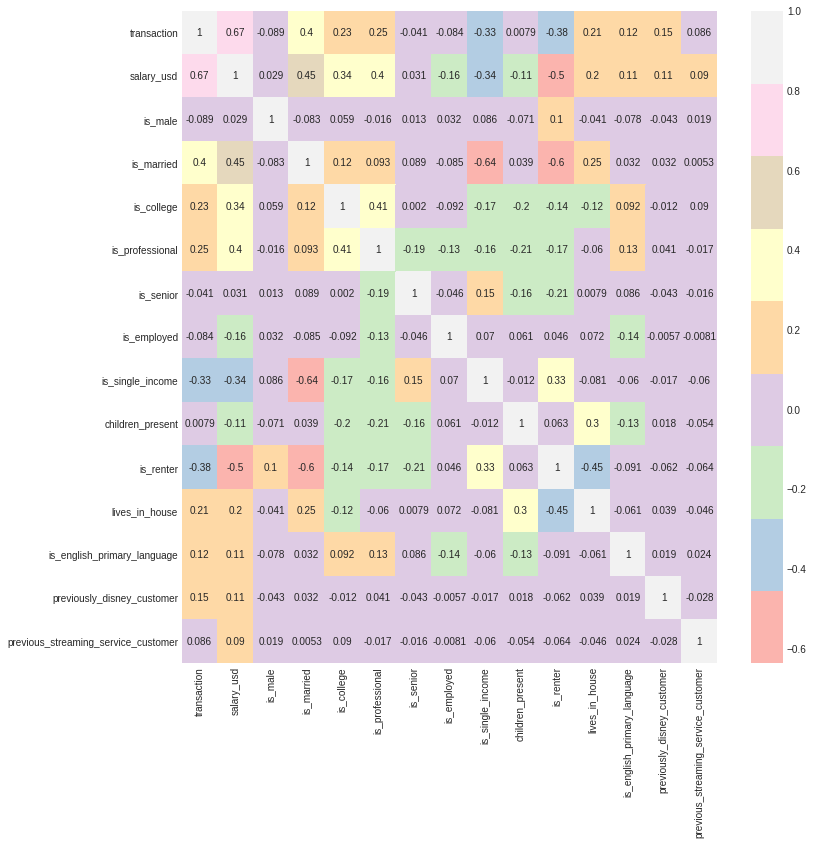

In [36]:
#correlation matrix
corrmat= transaction_df.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap="Pastel1",annot=True)

> ### 2.2 Significance Level Testing

**Next, we are to test the significance level (p-value) of each of the variables which have a relatively high correlation value above. Relatively high correlation, here in this case, are defined as having an absolute value thats higher than 0.2.**

In [37]:
transaction = transaction_df['transaction']

salary = transaction_df['salary_usd']
marriage = transaction_df['is_married']
education = transaction_df['is_college']
prof = transaction_df['is_professional']
income = transaction_df['is_single_income']
rent = transaction_df['is_renter']
house = transaction_df['lives_in_house']


#Salary
print('Salary:')
r, p = scipy.stats.pearsonr(salary, transaction)
print('P-value =', p)
alpha = 0.05
if p > alpha:
	print('Is not a significant key variable')
else:
	print('Is a significant key variable')
print()


#Marriage
print('Marriage:')
r, p = scipy.stats.pearsonr(marriage, transaction)
print('P-value =', p)
alpha = 0.05
if p > alpha:
	print('Is not a significant key variable')
else:
	print('Is a significant key variable')
print()


#Education
print('Education:')
r, p = scipy.stats.pearsonr(education, transaction)
print('P-value =', p)
alpha = 0.05
if p > alpha:
	print('Is not a significant key variable')
else:
	print('Is a significant key variable')
print()


#Professional
print('Professional:')
r, p = scipy.stats.pearsonr(prof, transaction)
print('P-value =', p)
alpha = 0.05
if p > alpha:
	print('Is not a significant key variable')
else:
	print('Is a significant key variable')
print()


#Income
print('Income:')
r, p = scipy.stats.pearsonr(income, transaction)
print('P-value =', p)
alpha = 0.05
if p > alpha:
	print('Is not a significant key variable')
else:
	print('Is a significant key variable')
print()


#Rent
print('Rent:')
r, p = scipy.stats.pearsonr(rent, transaction)
print('P-value =', p)
alpha = 0.05
if p > alpha:
	print('Is not a significant key variable')
else:
	print('Is a significant key variable')
print()


#House
print('House:')
r, p = scipy.stats.pearsonr(house, transaction)
print('P-value =', p)
alpha = 0.05
if p > alpha:
	print('Is not a significant key variable')
else:
	print('Is a significant key variable')
print()

Salary:
P-value = 2.8069320296274465e-68
Is a significant key variable

Marriage:
P-value = 1.7758557207215708e-20
Is a significant key variable

Education:
P-value = 1.5615050777039583e-07
Is a significant key variable

Professional:
P-value = 6.912410628540058e-09
Is a significant key variable

Income:
P-value = 2.383943778706645e-14
Is a significant key variable

Rent:
P-value = 2.867842025231084e-19
Is a significant key variable

House:
P-value = 1.23712013209021e-06
Is a significant key variable



## 3. Logistic Regression Analysis

> ### 3.1 Transaction vs Salary Model, Performance and Predictions

**According to findings above, salary is one of the most significant key variables, and follows with some other key variables such as marriage, rent, income, professional, education and house. Thus we are going to look at each of these key variables.**


**Conclusion:**

Customer's annual salary is highly impacting whether a transaction will be made or not. Based on findings below, customers who makes 10k or more annually are highly likely to make purchases than those one who don't.

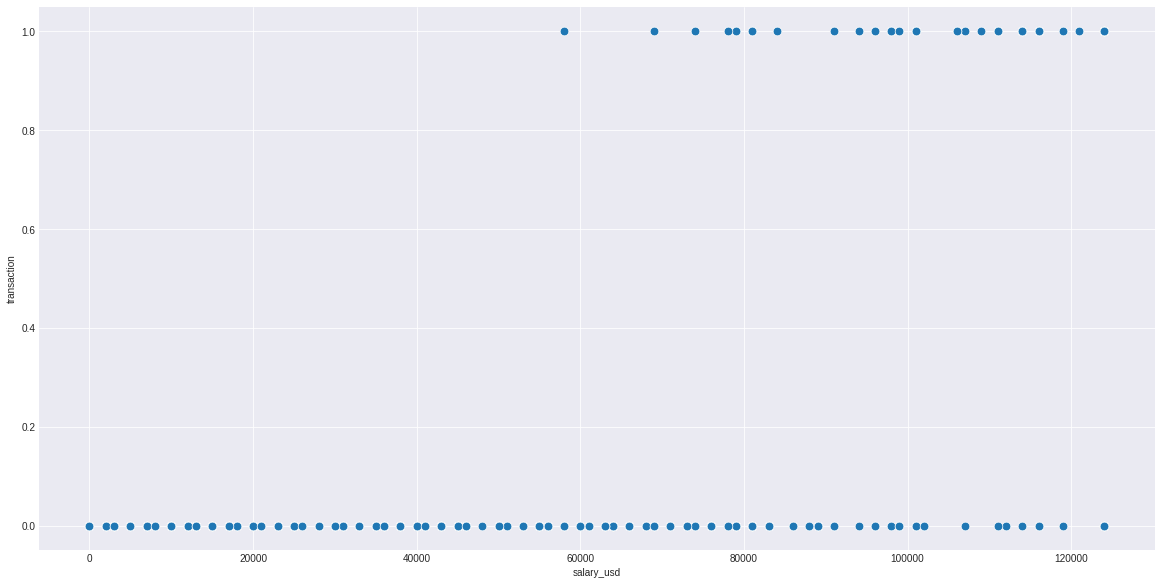

In [38]:
ax = sns.scatterplot(x = 'salary_usd', y = 'transaction', data = transaction_df, s = 75, palette = 'deep')

In [39]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(transaction_df[['salary_usd']], transaction_df[['transaction']], test_size = .2, random_state=10000)

#Initialize Logistic Regressor 
model = LogisticRegression()

#Fit the model
model.fit(X_train2, y_train2.values.ravel())

#Score the model
print(model.score(X_test2, y_test2))

X_test2

0.9306930693069307


,salary_usd
row,
363,7000
538,40000
587,13000
504,3000
262,99000
...,...
80,46000
640,61000
468,55000


In [40]:
#Get predictions for the test set.
#Each value corresponds to a transaction outcome of 0 (no) or 1 (yes)
model.predict(X_test2)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
#probabilities of each record.
#The structure below has two data points per record.
#The first data point contains the probability of this record NOT transacting
#The second data point contains the probability of this record transacting
model.predict_proba(X_test2).round(decimals=3)

array([[1.   , 0.   ],
       [0.996, 0.004],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.605, 0.395],
       [0.996, 0.004],
       [0.999, 0.001],
       [0.155, 0.845],
       [0.98 , 0.02 ],
       [0.876, 0.124],
       [0.996, 0.004],
       [0.985, 0.015],
       [0.155, 0.845],
       [0.782, 0.218],
       [0.876, 0.124],
       [0.985, 0.015],
       [0.999, 0.001],
       [0.998, 0.002],
       [0.356, 0.644],
       [0.999, 0.001],
       [1.   , 0.   ],
       [0.999, 0.001],
       [0.876, 0.124],
       [0.999, 0.001],
       [1.   , 0.   ],
       [0.458, 0.542],
       [0.999, 0.001],
       [0.876, 0.124],
       [0.993, 0.007],
       [0.856, 0.144],
       [0.155, 0.845],
       [0.901, 0.099],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.876, 0.124],
       [0.155, 0.845],
       [0.987, 0.013],
       [0.876, 0.124],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.993, 0.007],
       [0.997, 0.003],
       [0.876, 0.124],
       [0.5

In [42]:
# take a look at the actuals, predictions, and probabilities together
prediction_df = pd.DataFrame(model.predict(X_test2), columns = {'Prediction'}).set_index([pd.Index(X_test2.index)])
probability_df = pd.DataFrame(model.predict_proba(X_test2)).set_index([pd.Index(X_test2.index)])
all_df = X_test2.join(y_test2).join(prediction_df).join(probability_df)
all_df

,salary_usd,transaction,Prediction,0,1
row,,,,,
363,7000,0,0,0.999737,0.000263
538,40000,0,0,0.995678,0.004322
587,13000,0,0,0.999563,0.000437
504,3000,0,0,0.999813,0.000187
262,99000,0,0,0.604891,0.395109
...,...,...,...,...,...
80,46000,0,0,0.992824,0.007176
640,61000,0,0,0.974792,0.025208
468,55000,0,0,0.984707,0.015293


In [43]:
# use the model to predict transaction rate for arbitrary salaries
salary_arb_values = pd.DataFrame(data = {'salary_usd': [48000,65000,86000,105000,120000,150000]})
salary_arb_values.join(pd.DataFrame(model.predict(salary_arb_values), columns = {'Prediction'}).set_index([pd.Index(salary_arb_values.index)]))

,salary_usd,Prediction
0,48000,0
1,65000,0
2,86000,0
3,105000,1
4,120000,1
5,150000,1


In [44]:
#create a data structure that contains the probabilities for a range of salaries
exhaustive_data = {'salary_usd':range(200000)} 
exhaustive_data_df = pd.DataFrame(exhaustive_data)
prediction_df2 = pd.DataFrame(model.predict(exhaustive_data_df), columns = {'Prediction'}).set_index([pd.Index(exhaustive_data_df.index)])
probability_df2 = pd.DataFrame(model.predict_proba(exhaustive_data_df)).set_index([pd.Index(exhaustive_data_df.index)])
all_df2 = exhaustive_data_df.join(prediction_df2).join(probability_df2)
print(all_df2.head(10))
print()
print(all_df2.tail(10))

   salary_usd  Prediction         0         1
0           0           0  0.999855  0.000145
1           1           0  0.999855  0.000145
2           2           0  0.999855  0.000145
3           3           0  0.999855  0.000145
4           4           0  0.999855  0.000145
5           5           0  0.999855  0.000145
6           6           0  0.999855  0.000145
7           7           0  0.999855  0.000145
8           8           0  0.999855  0.000145
9           9           0  0.999855  0.000145

        salary_usd  Prediction         0         1
199990      199990           1  0.000287  0.999713
199991      199991           1  0.000287  0.999713
199992      199992           1  0.000287  0.999713
199993      199993           1  0.000287  0.999713
199994      199994           1  0.000287  0.999713
199995      199995           1  0.000287  0.999713
199996      199996           1  0.000287  0.999713
199997      199997           1  0.000287  0.999713
199998      199998           1  0.

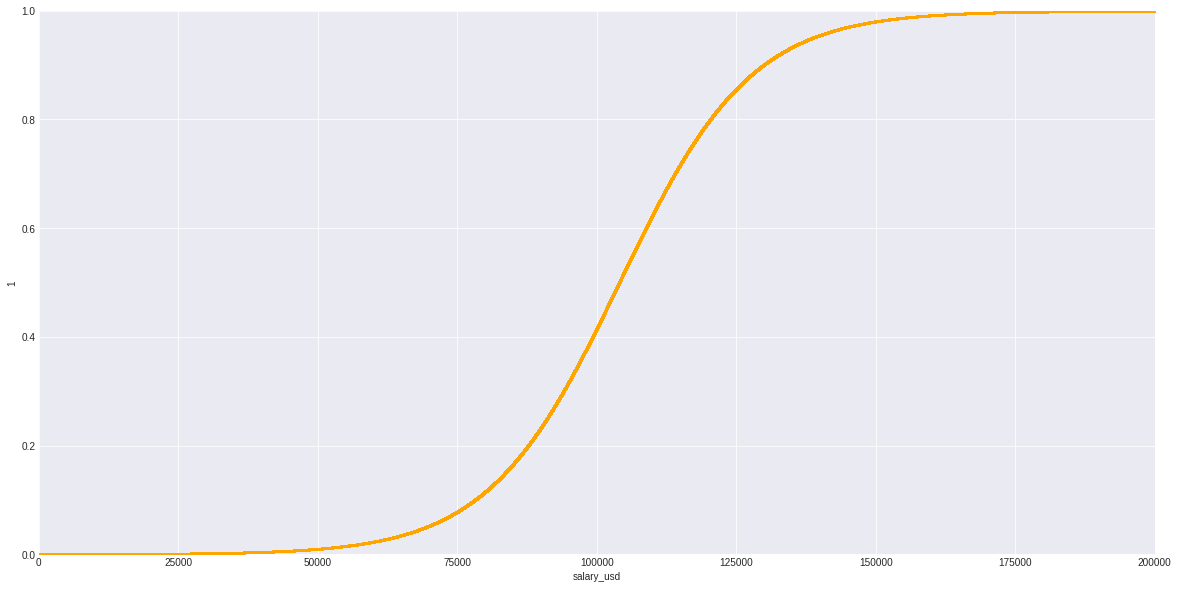

In [45]:
# plot results
ax = sns.scatterplot(x = 'salary_usd', y = 1, data = all_df2, s = 5, edgecolor = None, color = 'orange')
plt.xlim([0,200000])
plt.ylim([0,1]);

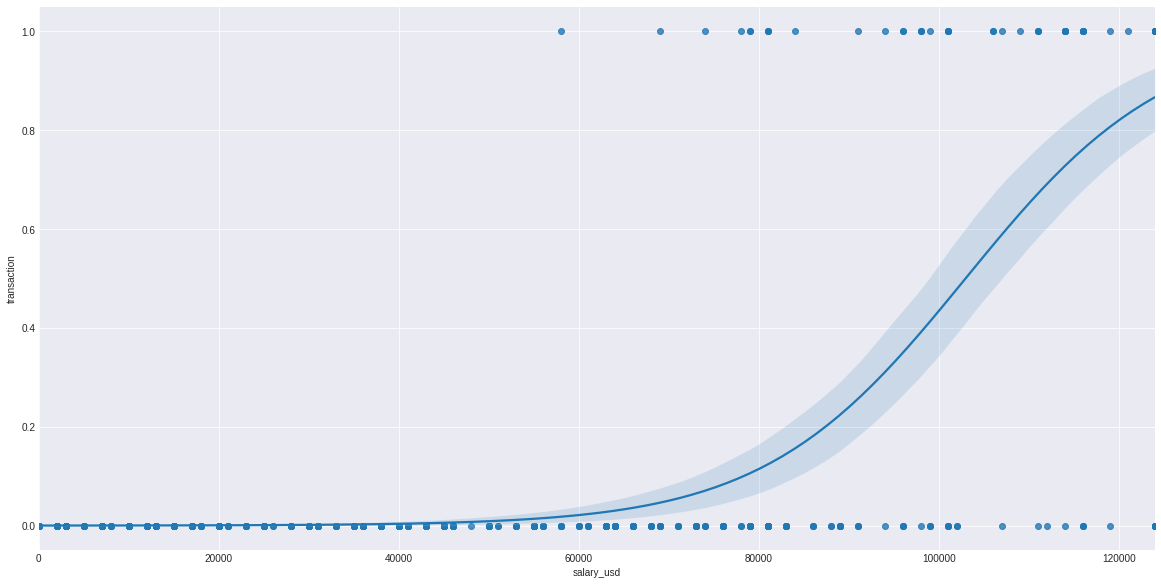

In [46]:
# plot data set with logistic regression
sns.regplot(x='salary_usd', y='transaction', data=transaction_df, logistic=True)


> ### 3.2 Explore Correlation Between Transactions and Other Key Variables
Observations:
*   Customers who lives in their own house is more likely to make transactions than renters.
*   Customers who have single income are not as likely to make transactions.
*   Customers who are married are more likely to make transactions.
*   Customers who are working professionals are slightly more likely to make transactions than those are still in college.



In [47]:
transac_1 = transaction_df.loc[transaction_df['transaction']==1]
transac_0 = transaction_df.loc[transaction_df['transaction']==0]
total_1 = len(transac_1)
total_0 = len(transac_0)

fig1 = go.Figure(data=[go.Bar(x=['is_married','is_college','is_professional',
                                 'is_single_income','is_renter','lives_in_house'], 
                              y =[transac_1['is_married'].sum(),
                                  transac_1['is_college'].sum(), 
                                  transac_1['is_professional'].sum(),
                                  transac_1['is_single_income'].sum(),
                                  transac_1['is_renter'].sum(), 
                                  transac_1['lives_in_house'].sum()], 
                                  name='Transact + True', marker=dict(color='darksalmon')),
                       go.Bar(x=['is_married','is_college','is_professional',
                                 'is_single_income','is_renter','lives_in_house'], 
                              y =[total_1-transac_1['is_married'].sum(),
                                  total_1-transac_1['is_college'].sum(), 
                                  total_1-transac_1['is_professional'].sum(),
                                  total_1-transac_1['is_single_income'].sum(),
                                  total_1-transac_1['is_renter'].sum(), 
                                  total_1-transac_1['lives_in_house'].sum()], 
                                  name='Transact = False', marker=dict(color='peachpuff')),
                       go.Bar(x=['is_married','is_college','is_professional',
                                 'is_single_income','is_renter','lives_in_house'], 
                              y =[transac_0['is_married'].sum(),
                                  transac_0['is_college'].sum(), 
                                  transac_0['is_professional'].sum(),
                                  transac_0['is_single_income'].sum(),
                                  transac_0['is_renter'].sum(), 
                                  transac_0['lives_in_house'].sum()], 
                                  name='Not transact + True', marker=dict(color='cadetblue')),
                       go.Bar(x=['is_married','is_college','is_professional',
                                 'is_single_income','is_renter','lives_in_house'], 
                              y =[total_0-transac_0['is_married'].sum(),
                                  total_0-transac_0['is_college'].sum(), 
                                  total_0-transac_0['is_professional'].sum(),
                                  total_0-transac_0['is_single_income'].sum(),
                                  total_0-transac_0['is_renter'].sum(), 
                                  total_0-transac_0['lives_in_house'].sum()], 
                                  name='Not transact + False', marker=dict(color='powderblue'))])
fig1.update_layout(barmode='stack', bargap=0.07, width=600, height=400)

# Part C: Salary Prediction with Regularization

## 1. Introducing Sport Player Salary Data




> ### 1.1 Acquiring Data and Basic Cleaning
*   Read data from Google Sheet
*   Remove any N/A data points


In [48]:
# Read data
data_salary_path="https://docs.google.com/spreadsheets/d/e/2PACX-1vSG-GQwdpZkTC-UV9cTMCjhSwkmc5VNb-IzH5yG6neHxk3dB_a-Ttlg-8Nynttq_NmnROAt-OZmx9Ax/pub?gid=1859113491&single=true&output=csv"
salary_df= pd.read_csv(data_salary_path)
salary_df

,Salary,count_at_bats,count_hits,count_home_runs,count_runs,RBI,count_walks,years_experience,cumulative_at_bats,cumulative_hits,cumulative_home_runs,cumulative_runs,cumulative_RBI,cumulative_walks,League,Division,PutOuts,Assists,Errors,NewLeague
0,875000,457,101,14,42,63,22,17,6521,1767,281,1003,977,619,A,W,389,39,4,A
1,1300000,441,118,28,84,86,68,8,2723,750,126,433,420,309,A,E,190,2,2,A
2,940000,593,152,23,69,75,53,6,2765,686,133,369,384,321,A,W,315,10,6,A
3,70000,312,68,2,32,22,24,1,312,68,2,32,22,24,A,E,86,150,15,A
4,815000,526,146,13,71,70,84,6,2648,715,77,352,342,289,N,W,303,9,9,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,0,209,59,6,20,37,27,4,884,209,14,66,106,92,N,E,415,35,3,N
239,0,225,61,5,32,26,26,11,1568,408,25,202,185,257,A,W,132,9,0,A
240,0,551,160,23,86,90,87,5,2235,602,75,278,328,273,A,W,1224,115,11,A
241,0,200,57,6,23,14,14,9,2516,684,46,371,230,195,N,W,69,1,1,N


> ### 1.2 Data Interpretation

In [49]:
# Drop incomplete entries
salary_df = salary_df.dropna()
salary_df = salary_df[salary_df['Salary']!=0]

print(salary_df.info())
salary_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 183
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Salary                184 non-null    int64 
 1   count_at_bats         184 non-null    int64 
 2   count_hits            184 non-null    int64 
 3   count_home_runs       184 non-null    int64 
 4   count_runs            184 non-null    int64 
 5   RBI                   184 non-null    int64 
 6   count_walks           184 non-null    int64 
 7   years_experience      184 non-null    int64 
 8   cumulative_at_bats    184 non-null    int64 
 9   cumulative_hits       184 non-null    int64 
 10  cumulative_home_runs  184 non-null    int64 
 11  cumulative_runs       184 non-null    int64 
 12  cumulative_RBI        184 non-null    int64 
 13  cumulative_walks      184 non-null    int64 
 14  League                184 non-null    object
 15  Division              184 non-null    ob

,Salary,count_at_bats,count_hits,count_home_runs,count_runs,RBI,count_walks,years_experience,cumulative_at_bats,cumulative_hits,cumulative_home_runs,cumulative_runs,cumulative_RBI,cumulative_walks,PutOuts,Assists,Errors
count,1.840000e+02,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,5.236196e+05,409.027174,109.364130,11.847826,55.353261,52.092391,41.304348,7.293478,2669.027174,724.342391,72.222826,366.576087,333.125000,264.864130,285.298913,118.391304,8.288043
std,4.085598e+05,141.387366,43.885133,8.428983,24.225268,25.075779,21.271207,4.862116,2297.547487,649.424711,83.689377,334.870654,320.087984,277.282634,272.208199,145.644110,6.596792
min,6.800000e+04,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000
25%,1.837500e+05,288.000000,75.500000,5.000000,35.000000,33.000000,24.750000,4.000000,896.750000,217.750000,16.000000,111.250000,96.750000,76.250000,117.500000,7.000000,3.000000
50%,4.275000e+05,416.000000,108.500000,10.000000,54.000000,47.500000,37.000000,6.000000,1953.500000,528.500000,41.500000,272.500000,254.500000,179.500000,223.000000,43.500000,6.000000
75%,7.500000e+05,528.000000,142.500000,18.000000,73.000000,71.250000,53.000000,10.000000,3772.500000,984.250000,97.000000,495.750000,422.750000,317.500000,316.750000,205.250000,12.250000
max,1.975000e+06,687.000000,238.000000,40.000000,117.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1377.000000,492.000000,32.000000


In [50]:
print(list(salary_df))

['Salary', 'count_at_bats', 'count_hits', 'count_home_runs', 'count_runs', 'RBI', 'count_walks', 'years_experience', 'cumulative_at_bats', 'cumulative_hits', 'cumulative_home_runs', 'cumulative_runs', 'cumulative_RBI', 'cumulative_walks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']


In [51]:
print(salary_df.League.unique())
print(salary_df.Division.unique())
print(salary_df.NewLeague.unique())

['A' 'N']
['W' 'E']
['A' 'N']


> ### 1.3 Perform Light Modification
*   Trim outliers







In [52]:
# Convert price with dollar sign to integer
salary_df['Salary'] = salary_df['Salary'].replace( '[\$,)]','', regex=True ).astype(float)


# Trim outliers:
starting_percentile = salary_df['Salary'].quantile(.01)
ending_percentile = salary_df['Salary'].quantile(.99)
salary_outliers = salary_df.loc[((salary_df['Salary'] <= starting_percentile) | 
                                         (salary_df['Salary'] >= ending_percentile))]
salary_df = salary_df.loc[((salary_df['Salary'] > starting_percentile) & 
                                     (salary_df['Salary'] < ending_percentile))]
salary_df.describe().round(2)


,Salary,count_at_bats,count_hits,count_home_runs,count_runs,RBI,count_walks,years_experience,cumulative_at_bats,cumulative_hits,cumulative_home_runs,cumulative_runs,cumulative_RBI,cumulative_walks,PutOuts,Assists,Errors
count,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00,176.00
mean,522880.68,412.90,110.41,11.98,55.87,52.47,41.71,7.47,2734.65,741.75,73.32,375.49,339.49,271.14,281.20,120.35,8.20
std,379750.61,139.01,42.51,8.27,23.58,24.23,21.39,4.83,2290.96,648.57,83.26,334.56,318.22,278.18,259.91,148.19,6.57
min,75000.00,19.00,4.00,0.00,2.00,3.00,1.00,1.00,19.00,4.00,0.00,2.00,3.00,1.00,0.00,0.00,0.00
25%,200000.00,301.75,76.00,5.00,36.75,34.75,25.75,4.00,930.75,233.50,17.00,124.75,103.00,80.00,121.00,7.00,3.00
50%,450000.00,418.50,110.00,10.00,54.50,48.00,38.00,6.00,2035.50,546.00,42.50,281.50,259.50,187.00,225.00,41.50,6.00
75%,750000.00,528.25,144.25,18.00,73.00,71.25,53.50,10.25,3838.75,1011.50,97.75,502.00,428.50,319.00,316.00,216.50,12.25
max,1900000.00,687.00,213.00,40.00,108.00,121.00,105.00,24.00,14053.00,4256.00,548.00,2165.00,1659.00,1566.00,1236.00,492.00,32.00


## 2. EDA & Regression Approach 


> ### 2.1 Explore Correlation Between Salary and Other Variables
**Using Pearson's R-Square Method**




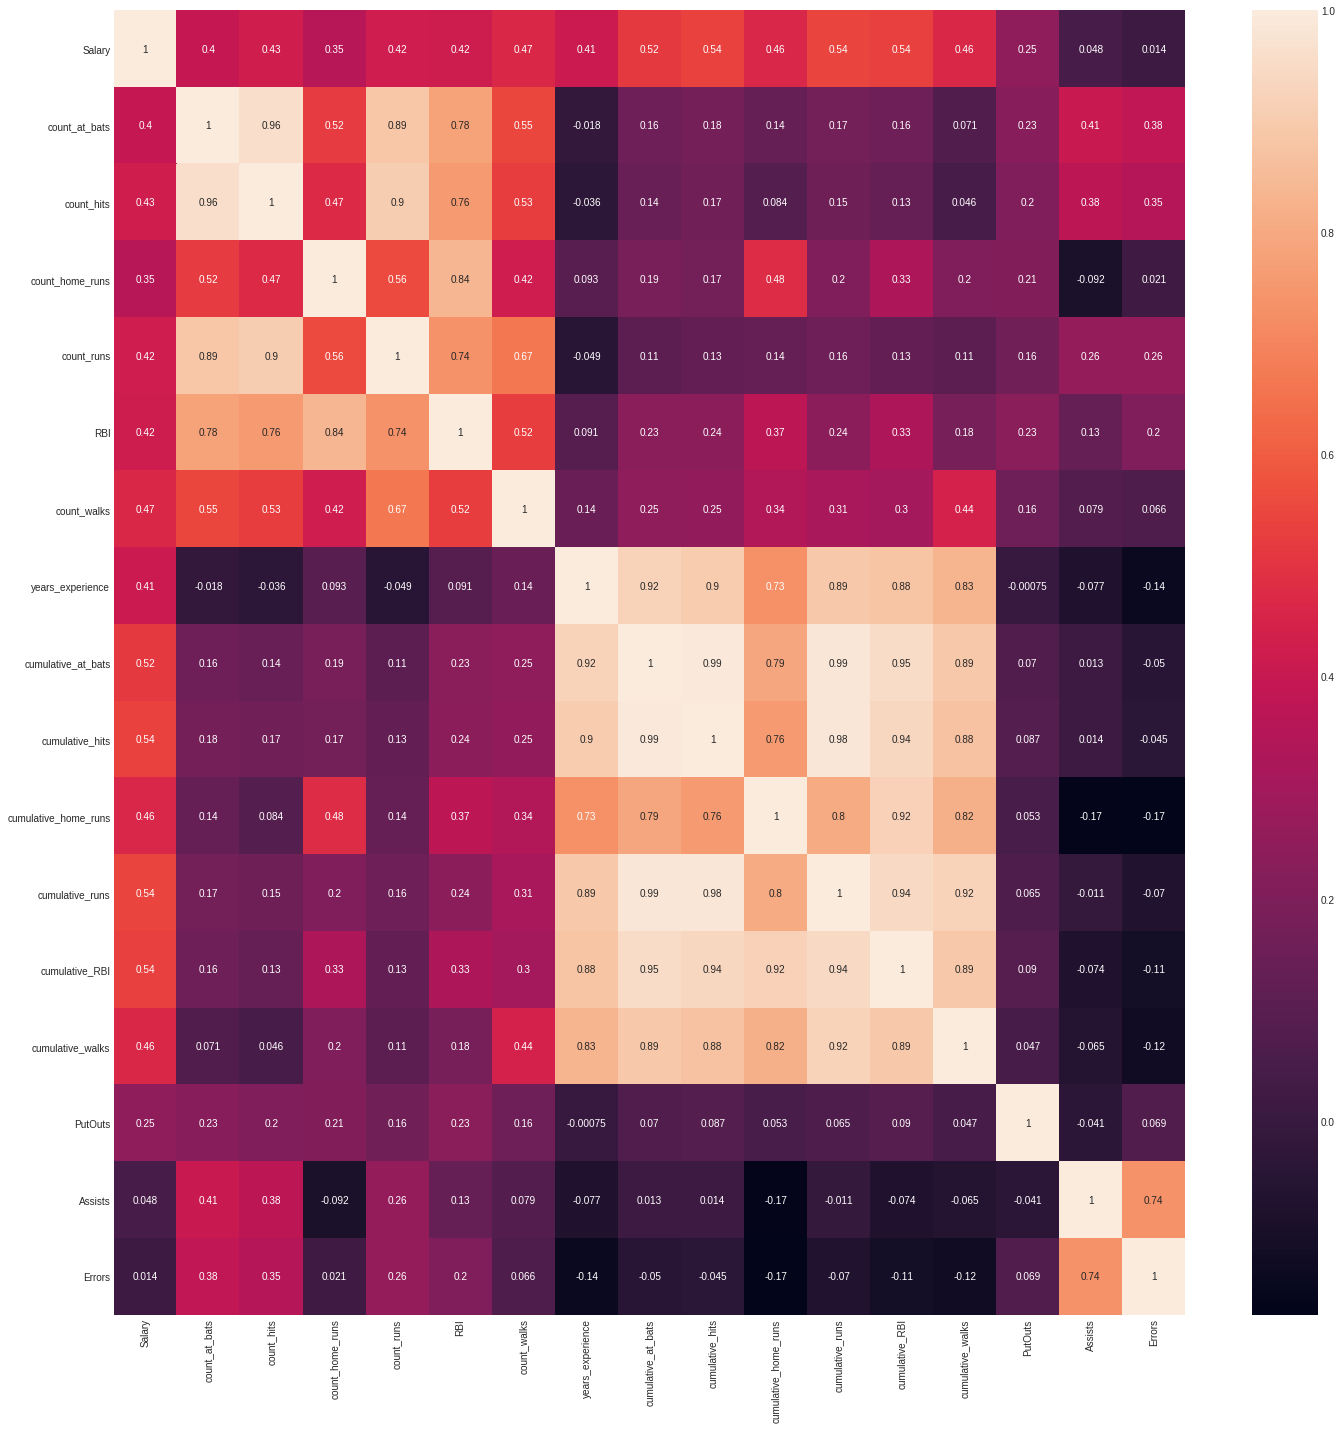

In [53]:
#correlation matrix
corrmat= salary_df.corr()
f, ax = plt.subplots(figsize=(24,24))
sns.heatmap(corrmat,cmap="rocket",annot=True)

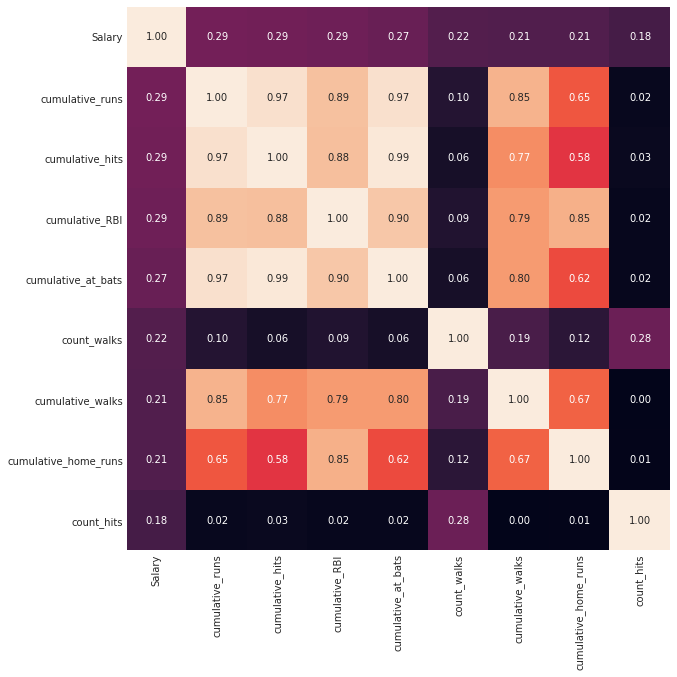

In [54]:
corrmat = salary_df.corr(method='pearson', min_periods=1)
r_square = corrmat ** 2

## Top 8 correlated variables
k = 9 #number of variables for heatmap
cols = r_square.nlargest(k, 'Salary')['Salary'].index
cm = salary_df[cols].corr()
cm_square = cm ** 2
f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm_square, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

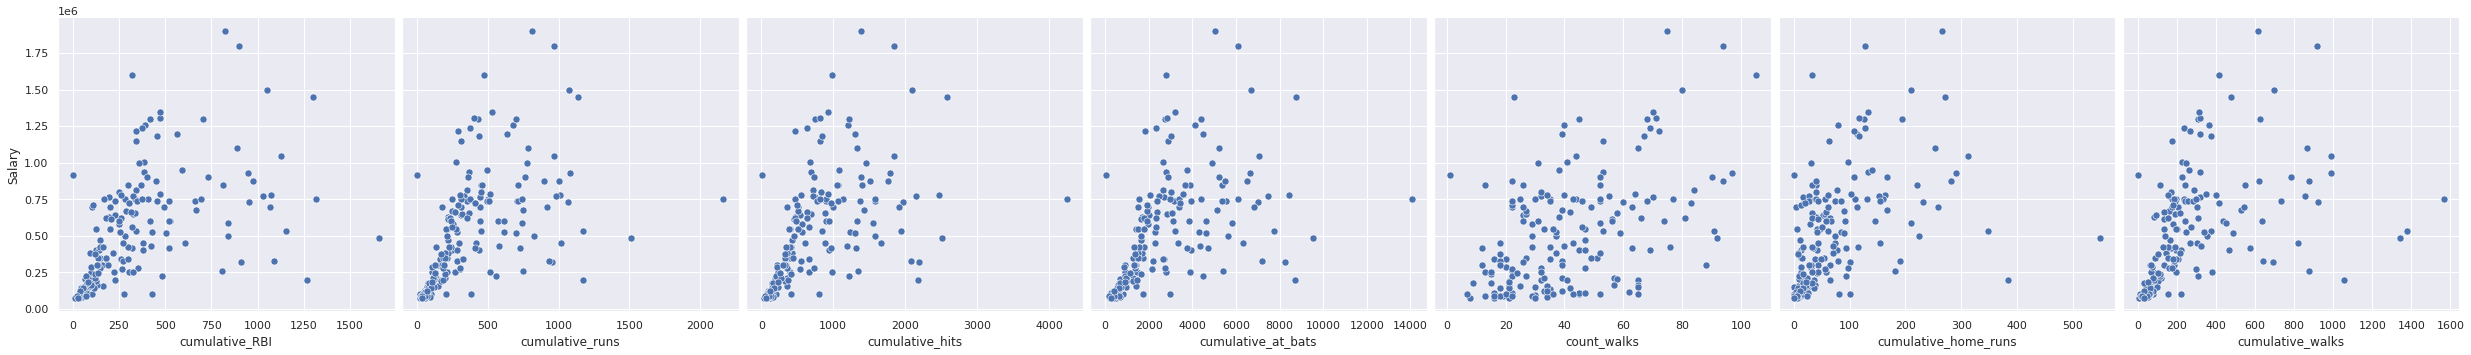

In [113]:
key_variables = salary_df[['cumulative_RBI','cumulative_runs','cumulative_hits','cumulative_at_bats','count_walks','cumulative_home_runs','cumulative_walks']]
salary_df_mod = salary_df[['Salary','cumulative_RBI','cumulative_runs','cumulative_hits','cumulative_at_bats','count_walks','cumulative_home_runs','cumulative_walks']]

# using scatter plots to visually indicate correlation
sns.set()
sns.pairplot(salary_df, x_vars=key_variables, y_vars = ['Salary'], 
             plot_kws={"s": 50}, palette = 'deep', height=5)

> ### 2.2 Fit Multi-linear and Linear Model

In [114]:
#Load the X data set
X = key_variables.values

#Initialize the data and column length variables
data_length = len(salary_df_mod)
column_length = len(key_variables.columns)

#Reshape and load remaining data sets
X = X.reshape(data_length,column_length)
y = salary_df_mod['Salary'].values
y = y.reshape(data_length,1)

#Split the data into training and testing sets @ random state 1
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=1)

In [115]:
# with statsmodels
multi_linear_model = sm.OLS(y_train, X_train).fit()
pred = multi_linear_model.predict(X_test)
multi_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.824
Model:                            OLS   Adj. R-squared (uncentered):              0.814
Method:                 Least Squares   F-statistic:                              77.80
Date:                Tue, 23 Feb 2021   Prob (F-statistic):                    7.86e-41
Time:                        17:08:28   Log-Likelihood:                         -1712.4
No. Observations:                 123   AIC:                                      3439.
Df Residuals:                     116   BIC:                                      3459.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            84.9055    808.637      0.105      0.917   -1516.702    1686.513
x2           645.2475    877.773      0.735      0.464   -1093.292    2383.787
x3           767.4930    691.590      1.110      0.269    -602.289    2137.275
x4          -174.0811    120.371     -1.446      0.151    -412.491      64.329
x5          8824.8719    848.341     10.403      0.000    7144.626    1.05e+04
x6           753.6964   1802.759      0.418      0.677   -2816.894    4324.287
x7         -1002.2720    322.937     -3.104      0.002   -1641.890    -362.654
==============================================================================
Omnibus:                        8.570   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                9.680
Skew:                           0.453   Prob(JB):                      0.00791
Kurtosis:                       4.033   Cond. No.                         346.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
#Create the linear regression model and fit
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_pred_y = lin_reg.predict(X_test)

# train and test score:
lin_train_score=lin_reg.score(X_train, y_train)
lin_test_score=lin_reg.score(X_test, y_test)

print("Linear Model Train Score =", lin_train_score)
print("Linear Model Test Score =", lin_test_score)

# Explained variance score:
print("Variance Score (R^2):%.2f" % r2_score(y_test, lin_pred_y))

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, lin_pred_y))

#Performance Metric: Mean Squared Error
print("Root Mean Squared Error (RMSE): %.2f" % np.sqrt(metrics.mean_squared_error(y_test, lin_pred_y)))

# Check coefficients
print("Coefficients: ", lin_reg.coef_.round(3))

Linear Model Train Score = 0.4956802204173637
Linear Model Test Score = 0.45072347478577157
Variance Score (R^2):0.45
Mean Squared Error (MSE):78905297915.56
Root Mean Squared Error (RMSE): 280900.87
Coefficients:  [[  64.09   612.814  904.409 -219.788 8093.759  878.157 -912.256]]


## 3. Model Regularization

>### 3.1 Ridge Regression

>#### 3.1.1 Develope Ridge Regression Model
**Use tested alpha values**

In [117]:
#Create the ridge regression model 1 (with alpha=0.001) and fit
ridge_1 = Ridge(alpha=0.001)
ridge_1.fit(X_train, y_train)
ridge_1_pred_y = ridge_1.predict(X_test)


# train and test score:
ridge_1_train_score=ridge_1.score(X_train, y_train)
ridge_1_test_score=ridge_1.score(X_test, y_test)

print("Ridge Model 1 Train Score =", ridge_1_train_score)
print("Ridge Model 1 Test Score =", ridge_1_test_score)

# Explained variance score:
print("Variance Score (R^2):%.2f" % r2_score(y_test, ridge_1_pred_y))

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, ridge_1_pred_y))

#Performance Metric: Mean Squared Error
print("Root Mean Squared Error (RMSE): %.2f" % np.sqrt(metrics.mean_squared_error(y_test, ridge_1_pred_y)))

# Check coefficients
print("Coefficients: ", ridge_1.coef_.round(3))

Ridge Model 1 Train Score = 0.4956802204173638
Ridge Model 1 Test Score = 0.4507234777532243
Variance Score (R^2):0.45
Mean Squared Error (MSE):78905297489.27
Root Mean Squared Error (RMSE): 280900.87
Coefficients:  [[  64.09   612.814  904.409 -219.788 8093.758  878.157 -912.256]]


In [118]:
#Create the ridge regression model 2 (with alpha=100) and fit
ridge_2 = Ridge(alpha=100)
ridge_2.fit(X_train, y_train)
ridge_2_pred_y = ridge_2.predict(X_test)


# train and test score:
ridge_2_train_score=ridge_2.score(X_train, y_train)
ridge_2_test_score=ridge_2.score(X_test, y_test)

print("Ridge Model 2 Train Score =", ridge_2_train_score)
print("Ridge Model 2 Test Score =", ridge_2_test_score)

# Explained variance score:
print("Variance Score (R^2):%.2f" % r2_score(y_test, ridge_2_pred_y))

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, ridge_2_pred_y))

#Performance Metric: Mean Squared Error
print("Root Mean Squared Error (RMSE): %.2f" % np.sqrt(metrics.mean_squared_error(y_test, ridge_2_pred_y)))

# Check coefficients
print("Coefficients: ", ridge_2.coef_.round(3))

Ridge Model 2 Train Score = 0.49567926062947043
Ridge Model 2 Test Score = 0.4510186506967637
Variance Score (R^2):0.45
Mean Squared Error (MSE):78862894968.91
Root Mean Squared Error (RMSE): 280825.38
Coefficients:  [[  64.441  613.047  905.642 -220.378 8072.839  878.253 -910.379]]


>#### 3.1.2 Find the most fitted model with the best performance
**Using Ridge CV to select the best alpha, within an array of alpha values, in order to achieve best performance**

In [119]:
# create an array of alpha values
alpha_range = 10.**np.arange(-5, 5)
alpha_range

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])

In [120]:
# select the best alpha
ridgecv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error', cv=10)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.01

In [121]:
# predict method uses the best alpha value
ridgereg = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred_rr = ridgereg.predict(X_test)

# train and test score:
ridgereg_train_score=ridgereg.score(X_train, y_train)
ridgereg_test_score=ridgereg.score(X_test, y_test)

print("Ridge Model with Best Alpha Train Score =", ridgereg_train_score)
print("Ridge Model with Best Alpha Test Score =", ridgereg_test_score)

# calculate R^2 value, MSE, RMSE
print('Variance Score (R^2):%.2f' % r2_score(y_test, y_pred_rr))
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, y_pred_rr))
print("Root Mean Squared Error (RMSE): %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_rr)))

# Check coefficients
print("Coefficients: ", ridgereg.coef_.round(3))

Ridge Model with Best Alpha Train Score = 0.48644342957602194
Ridge Model with Best Alpha Test Score = 0.42036606271030463
Variance Score (R^2):0.42
Mean Squared Error (MSE):83266235501.27
Root Mean Squared Error (RMSE): 288558.89
Coefficients:  [[ 171.485  562.159  305.406  -38.939 8379.045  328.619 -941.754]]


>### 3.2 Lasso Regression

>#### 3.2.1 Develope Lasso Regression Model
**Use tested alpha values**

In [122]:
# try alpha = 0.001
lasso_1 = Lasso(alpha=0.001, normalize=True)
lasso_1.fit(X_train, y_train)
lasso_1_pred_y = lasso_1.predict(X_test)

# train and test score:
lasso_1_train_score=lasso_1.score(X_train, y_train)
lasso_1_test_score=lasso_1.score(X_test, y_test)

print("Lasso Model with Best Alpha Train Score =", lasso_1_train_score)
print("Lasso Model with Best Alpha Test Score =", lasso_1_test_score)

# calculate R^2 value, MSE, RMSE
print('Variance Score (R^2):%.2f' % r2_score(y_test, lasso_1_pred_y))
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, lasso_1_pred_y))
print("Root Mean Squared Er ror (RMSE): %.2f" % np.sqrt(metrics.mean_squared_error(y_test, lasso_1_pred_y)))
print("Coefficients: ", lasso_1.coef_.round(3))

Lasso Model with Best Alpha Train Score = 0.4956420383291078
Lasso Model with Best Alpha Test Score = 0.45156714882358084
Variance Score (R^2):0.45
Mean Squared Error (MSE):78784101490.37
Root Mean Squared Er ror (RMSE): 280685.06
Coefficients:  [ 121.191  691.342  841.826 -214.39  8115.741  741.153 -936.719]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4442155974490.638, tolerance: 1761775107.317073



>#### 3.2.2 Find the most fitted model with the best performance
**Using Ridge CV to select the best alpha, within an array of alpha values, in order to achieve best performance**

In [123]:
lassocv = LassoCV(n_alphas=500, normalize=True, random_state=1, cv=10)
lassocv.fit(X_train, y_train)
print('alpha =',lassocv.alpha_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



alpha = 262.2674017049971


In [147]:
# predict method uses the best alpha value
lassoreg = Lasso(alpha=lassocv.alpha_, normalize=True)
lassoreg.fit(X_train, y_train)
y_pred_lr = lassoreg.predict(X_test)

# train and test score:
lassoreg_train_score=lassoreg.score(X_train, y_train)
lassoreg_test_score=lassoreg.score(X_test, y_test)

print("Lasso Model with Best Alpha Train Score =", lassoreg_train_score)
print("Lasso Model with Best Alpha Test Score =", lassoreg_test_score)

# calculate R^2 value, MSE, RMSE
print('Variance Score (R^2):%.2f' % r2_score(y_test, y_pred_lr))
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, y_pred_lr))
print("Root Mean Squared Error (RMSE): %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))

# Check coefficients
print("Coefficients :", lassoreg.coef_.round(3))

Lasso Model with Best Alpha Train Score = 0.48182648418479523
Lasso Model with Best Alpha Test Score = 0.40372116012106174
Variance Score (R^2):0.40
Mean Squared Error (MSE):85657328033.52
Root Mean Squared Error (RMSE): 292672.73
Coefficients : [   0.     436.512  279.616   -0.    8400.54   542.351 -915.682]


>### 3.3 Regularized Model Comparison

In [145]:
coef_matrix=pd.DataFrame(index=['linear reg coef','ridge reg coef','lasso reg coef'], columns=['cumulative_RBI','cumulative_runs','cumulative_hits','cumulative_at_bats','count_walks','cumulative_home_runs','cumulative_walks'])
coef_matrix.loc['linear reg coef'] = lin_reg.coef_.round(3)
coef_matrix.loc['ridge reg coef'] = ridgereg.coef_.round(3)
coef_matrix.loc['lasso reg coef'] = lassoreg.coef_.round(3)
coef_matrix

,cumulative_RBI,cumulative_runs,cumulative_hits,cumulative_at_bats,count_walks,cumulative_home_runs,cumulative_walks
linear reg coef,64.09,612.814,904.409,-219.788,8093.76,878.157,-912.256
ridge reg coef,171.485,562.159,305.406,-38.939,8379.05,328.619,-941.754
lasso reg coef,0,436.512,279.616,-0,8400.54,542.351,-915.682


Comparing to linear regression model, ridge regression model had reduced the model complexity by shrinking most of the coefficients, especailly huge reductions on cumulative hits, cumulative at bats, and cumulative home runs. Ridge model had also slightly increased some of the coefficients such as cumulative RBI, counts walks, cumulative walks. This may due to the fact that Ridge tend to adjust the weight of each variable, by shrink the ones that are less relative and make those that are more important weight more.

The Lasso model performed feature selection in this case. The Lasso model output excluded 2 features "cumulative RBI" and "cumulative at bats" by shirnk those coefficients to 0. And it basically shrinked all other coefficients as well.

Investigating on other scores of all three models, Lasso model has the lowest variance score (0.4) where the linear model has a variance score of 0.45, and the ridge model has a score of 0.42 which is slightly lower than linear. Although, none of the ridge or lasso model has a higher train or test score than the linear model. 